In [1]:
import jax
import gymnax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from rebayes_mini.methods import low_rank_last_layer as onflow
from rebayes_mini.callbacks import get_null

In [2]:
sns.set_palette("colorblind")

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
%load_ext autoreload
%autoreload 2

## Could you learn?

In [5]:
class CNN(nn.Module):
    num_actions: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.elu(x)
        x = nn.Dense(features=84)(x)
        x = nn.elu(x)
        # x = nn.Dense(20)(x)
        # x = nn.relu(x)
        x = nn.Dense(self.num_actions, name="last_layer")(x)
        # x = x - jax.nn.logsumexp(x)
        return x.squeeze()

model = CNN(num_actions=10)

## Setup environment

In [6]:
key = jax.random.PRNGKey(3141)

key_env, key_env_step, key_act, key_init_params, key_run = jax.random.split(key, 5)

params_init = model.init(key_init_params, jnp.ones((28, 28, 1)))

# Initialise

In [7]:
# Instantiate the environment & its settings.
env, env_params = gymnax.make("MNISTBandit-bsuite")

# Reset the environment.
context, state = env.reset(key_env, env_params)

# Initialise agent
params_init = model.init(key_init_params, context[..., None])

# Sample a random action.
action = env.action_space(env_params).sample(key_act)

context_init, state_init, reward, done, _ = env.step(key_env_step, state, action, env_params)

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


## Online learning: full information setting

In [8]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    mean = jax.nn.softmax(eta)
    return mean


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [9]:
new_mapping = jax.random.choice(key, 10, (10,), replace=False).astype(jnp.uint8)
new_mapping

Array([8, 4, 2, 0, 3, 7, 6, 9, 1, 5], dtype=uint8)

In [10]:
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Obtain reward
    label_truth = env_state.correct_label
    # label_truth = jax.lax.cond(
    #     t < 10_000, # Permute label after 20_000
    #     lambda: label_truth,
    #     lambda: new_mapping[label_truth]
    # )
    y = jax.nn.one_hot(label_truth, 10)

    # Update belief
    action = agent.mean_fn(bel.mean_hidden, bel.mean_last, context[..., None]).argmax()
    bel_update = agent.update(bel, y, context[..., None])

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (y, reward)

In [11]:
agent = onflow.LowRankLastLayer(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_hidden=0.0,
    dynamics_last=0.0
)

In [12]:
%%time
bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)
u_init = (bel_init, context_init, state_init)
steps = 20_000

state_final, (actions, rewards_fullinfo) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_fullinfo = jax.block_until_ready(rewards_fullinfo)
rewards_fullinfo = (rewards_fullinfo + 1) / 2

CPU times: user 18.7 s, sys: 926 ms, total: 19.6 s
Wall time: 33.5 s


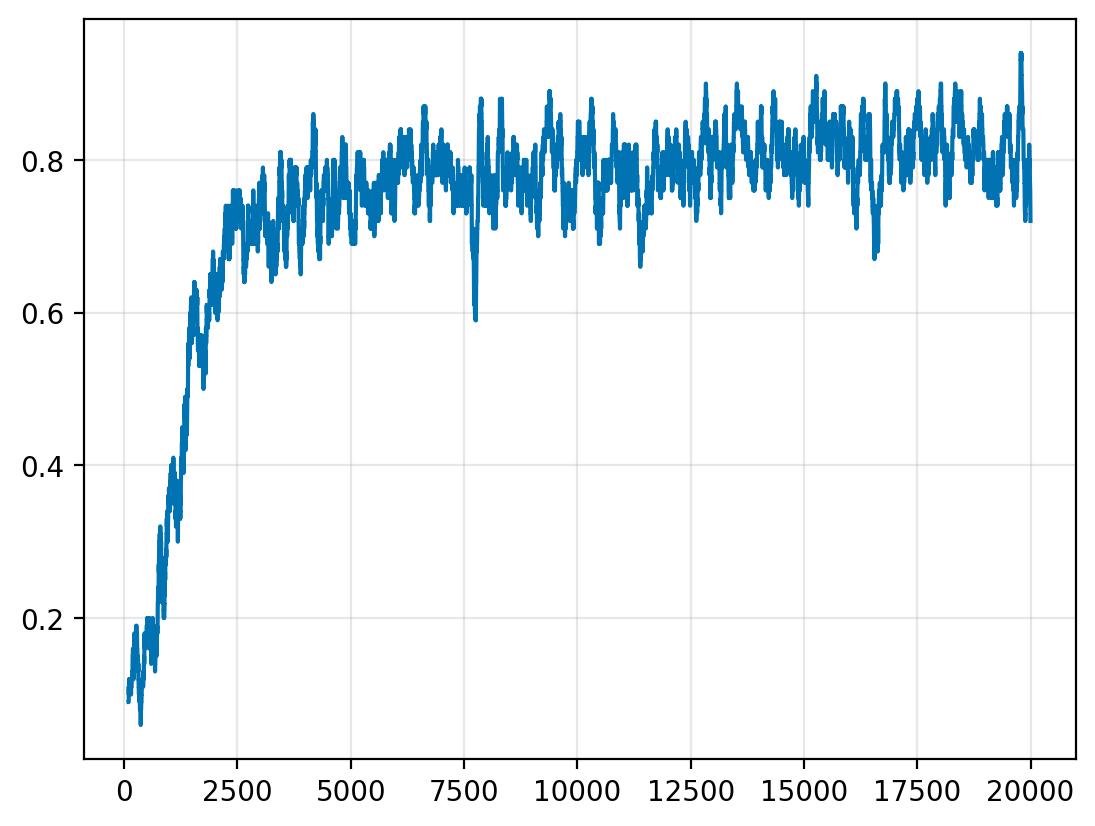

In [13]:
pd.Series(rewards_fullinfo).rolling(100).mean().plot()
plt.grid(alpha=0.3)

# Partial information

## OnFlow: $\epsilon$-greedy

In [14]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        return eta


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [15]:
eps = 0.05
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Take action
    key_eps, key_take = jax.random.split(key_take)
    yhat = agent.mean_fn(bel.mean_hidden, bel.mean_last, context[..., None])
    action = yhat.argmax()
    take_random = jax.random.bernoulli(key_eps, p=eps)
    action_random = jax.random.choice(key_take, 10)

    action = action * (1 - take_random) + action_random * take_random
    action = action.astype(int)
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    X = (action, context[..., None])
    bel_update = agent.update(bel, y, X)

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [16]:
%%time
agent = onflow.LowRankLastLayer(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_hidden=0.0,
    dynamics_last=0.0
)


bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)
u_init = (bel_init, context_init, state_init)

state_final, (actions, rewards_eps) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_eps = jax.block_until_ready((rewards_eps + 1) / 2)

CPU times: user 13.2 s, sys: 348 ms, total: 13.5 s
Wall time: 28.7 s


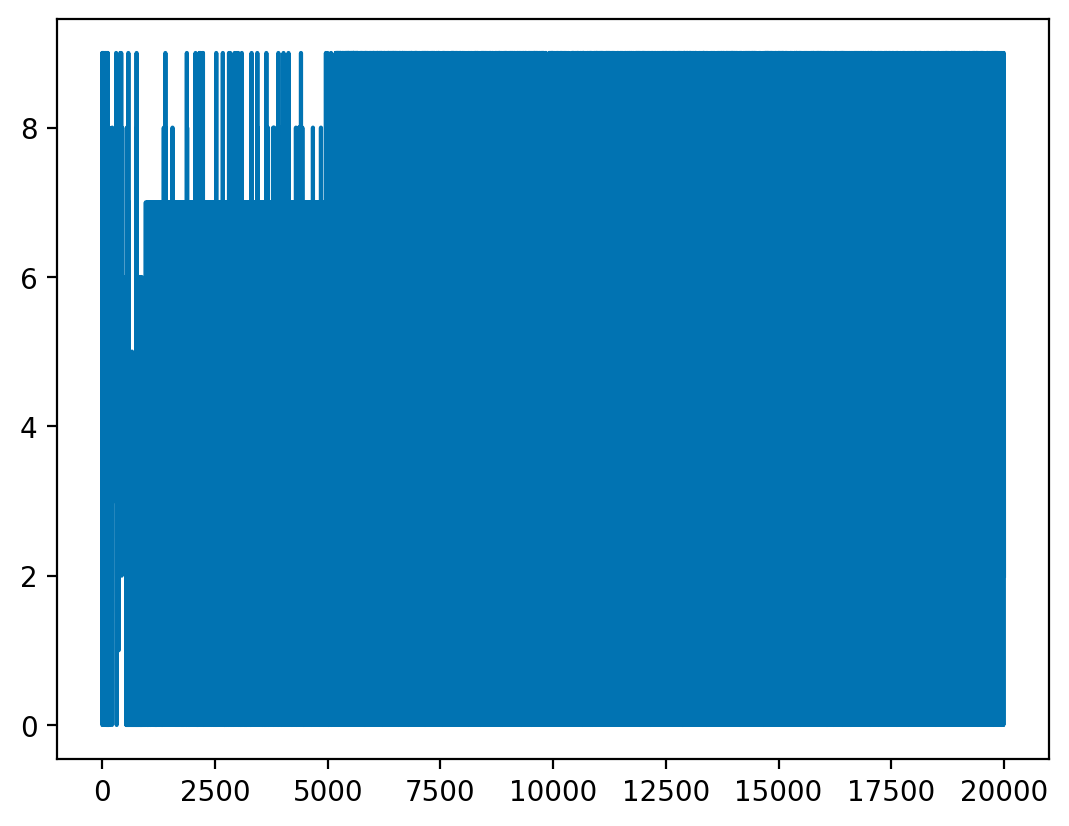

In [17]:
plt.plot(actions)

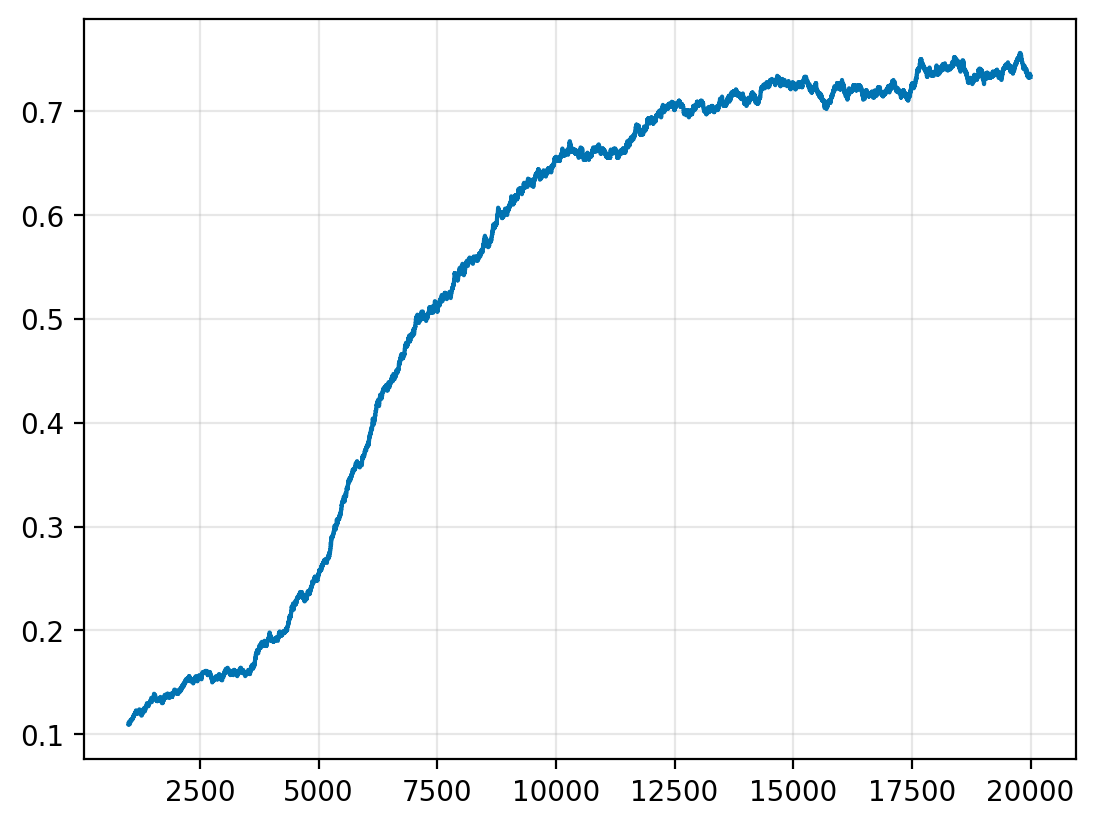

In [18]:
pd.Series(rewards_eps).rolling(1000).mean().plot()
plt.grid(alpha=0.3)

## LRKF $\epsilon$-greedy

In [19]:
from rebayes_mini.methods import low_rank_filter_revised as lrkf

In [20]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        return eta


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [21]:
eps = 0.05
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state

    # Take action
    key_eps, key_take = jax.random.split(key_take)
    yhat = agent.mean_fn(bel.mean, context[..., None])
    action = yhat.argmax()
    take_random = jax.random.bernoulli(key_eps, p=eps)
    action_random = jax.random.choice(key_take, 10)

    action = action * (1 - take_random) + action_random * take_random
    action = action.astype(int)
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    X = (action, context[..., None])
    bel_update = agent.update(bel, y, X)

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [22]:
%%time
agent = lrkf.LowRankCovarianceFilter(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_covariance=1e-3
)


bel_init = agent.init_bel(params_init, low_rank_diag=True, cov=1.0)
u_init = (bel_init, context_init, state_init)

(bel_final, _, _), (actions, rewards_lrkf) = jax.lax.scan(step, u_init, jnp.arange(40_000))
rewards_lrkf = jax.block_until_ready((rewards_lrkf + 1) / 2)

CPU times: user 8.93 s, sys: 195 ms, total: 9.12 s
Wall time: 17 s


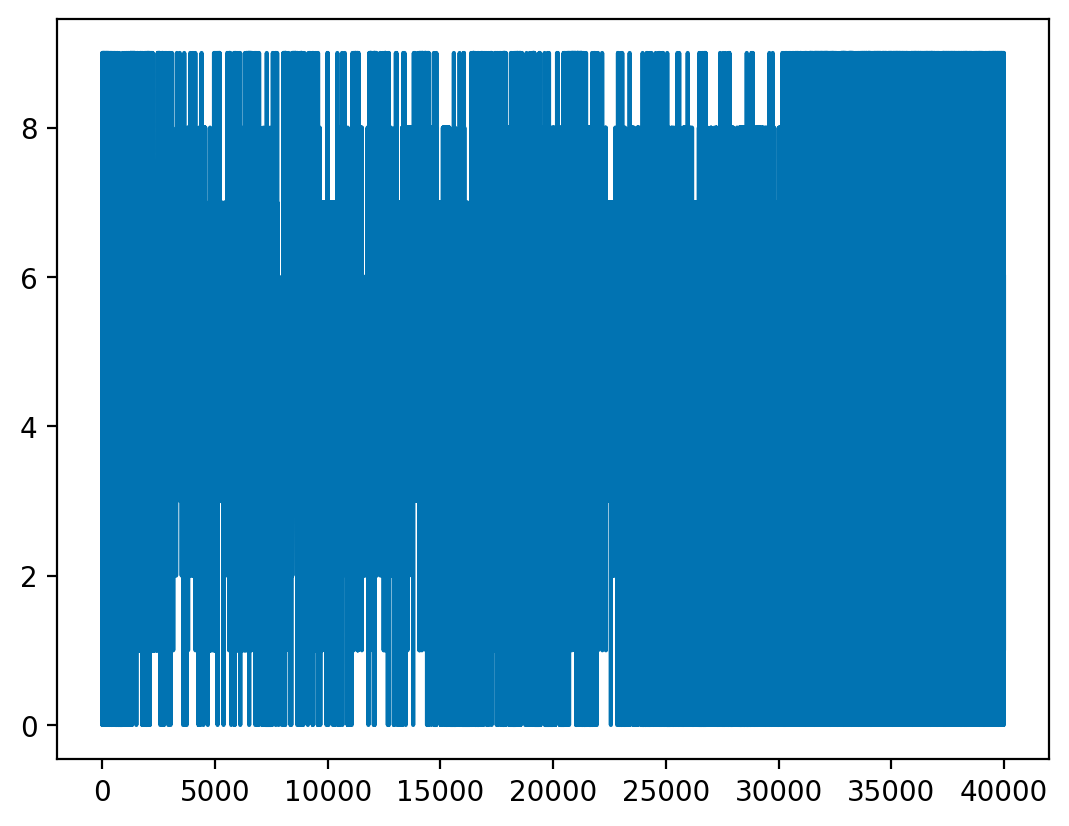

In [23]:
plt.plot(actions)

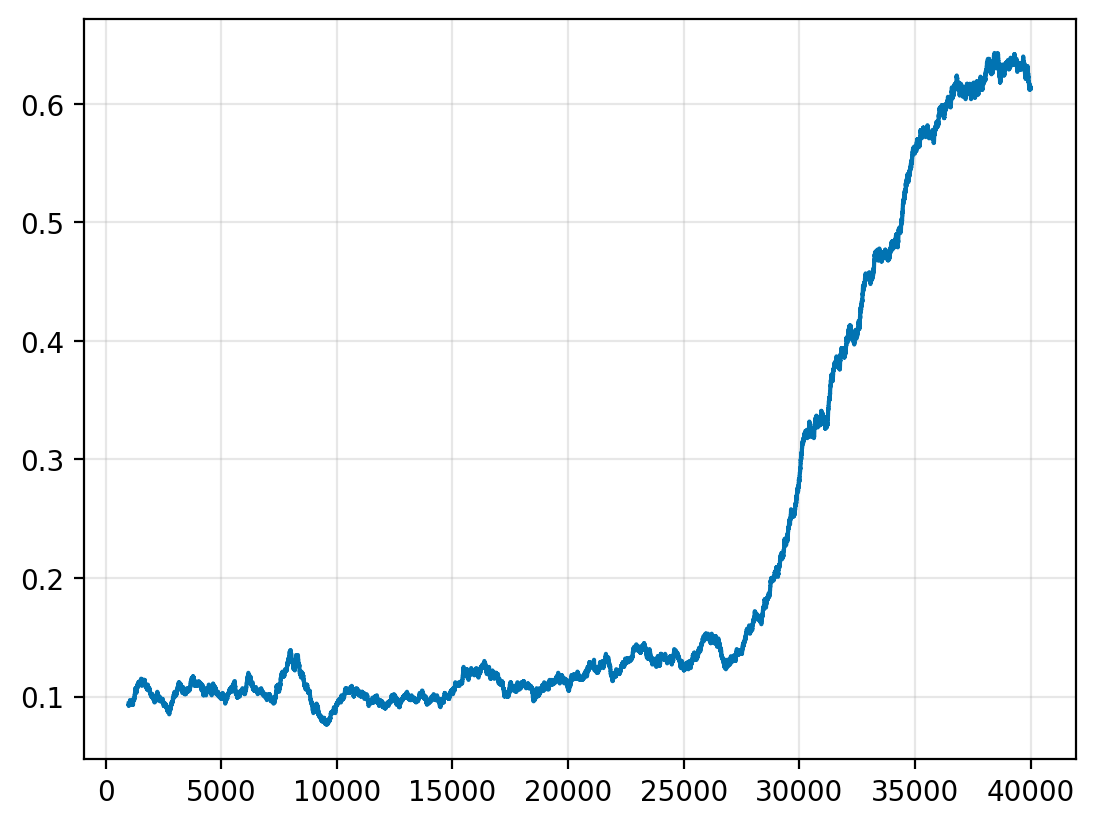

In [24]:
pd.Series(rewards_lrkf).rolling(1000).mean().plot()
plt.grid(alpha=0.3)

## LLA-$\epsilon$

In [25]:
import optax
from rebayes_mini.methods import replay_sgd

In [ ]:
from vbll_fifo import  FifoLaplaceDiag
from jax.flatten_util import ravel_pytree

In [27]:
def mean_fn_ll(params, x):
    if isinstance(x, tuple):
        action = x[:, 0].astype(int)
        x = x[:, 1:].reshape(-1, 28, 28, 1)
        eta = model.apply(params, x)
        import pdb; pdb.set_trace() 
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        x = x.reshape(-1, 28, 28, 1)
        eta = model.apply(params, x)
        return eta

In [286]:
def mean_fn_ll(params, x):
    x = jnp.atleast_2d(x)
    if (len(x[0]) == 28 ** 2 + 1):
        action = x[:, 0].astype(int)
        x = x[:, 1:].reshape(-1, 28, 28, 1)
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    elif (len(x[0]) == 28 ** 2)  or (x.shape[1:] == (28, 28, 1)) or (x.shape == (28, 28, 1)):
        x = x.reshape(-1, 28, 28, 1)
        eta = model.apply(params, x)
        return eta
    else:
        raise ValueError("Somethig's wrong")

In [287]:
eps = 0.05
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state

    # Take action
    key_eps, key_take = jax.random.split(key_take)
    yhat = agent.mean_fn(bel.mean, context.ravel())
    action = yhat.argmax()
    take_random = jax.random.bernoulli(key_eps, p=eps)
    action_random = jax.random.choice(key_take, 10)

    action = action * (1 - take_random) + action_random * take_random
    action = action.astype(int)
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    # X = (action, context[..., None])
    X = jnp.concat([jnp.array([action]), context.ravel()])
    bel_update = agent.update(bel, y, X)

    
    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [359]:
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Take action
    yhat = agent.sample_predictive(key_take, bel, context[..., None])
    action = yhat.argmax()
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    X = jnp.concat([jnp.array([action]), context.ravel()])
    # X = (action, context[..., None])
    bel_update = agent.update(bel, y, X)

    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [361]:
def lossfn(params, counter, x, y, apply_fn, noise=0.1):
    x = jnp.atleast_2d(x)
    action = x[:, 0].astype(int)
    x = x[:, 1:].reshape(-1, 28, 28, 1)
    res = apply_fn(params, x)

    params_flat, _ = ravel_pytree(params)
    
    yhat = jnp.take_along_axis(jnp.atleast_2d(res), action[:, None], axis=-1).squeeze()
    yhat = jax.nn.sigmoid(yhat)
    y = y.squeeze()

    log_likelihood = y * jnp.log(yhat) + (1 - y) * jnp.log1p(-yhat)
    log_likelihood = (log_likelihood * counter).sum() / counter.sum()
    return -log_likelihood #+ 0.1 * jnp.power(params_flat, 2).mean()


learning_rate = 1e-4
buffer_size = 5
n_inner = 5
agent = FifoLaplaceDiag(
    mean_fn_ll,
    lossfn,
    tx=optax.adamw(learning_rate),
    # tx=optax.contrib.muon(learning_rate),
    buffer_size=buffer_size,
    # dim_features=(28, 28, 1),
    dim_features = 28 ** 2 + 1,
    dim_output=1,
    n_inner=n_inner,
)

In [ ]:
%%time
bel_init = agent.init_bel(params_init)
u_init = (bel_init, context_init, state_init)

state_final, (actions, rewards_lll) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_lll = jax.block_until_ready((rewards_lll + 1) / 2)

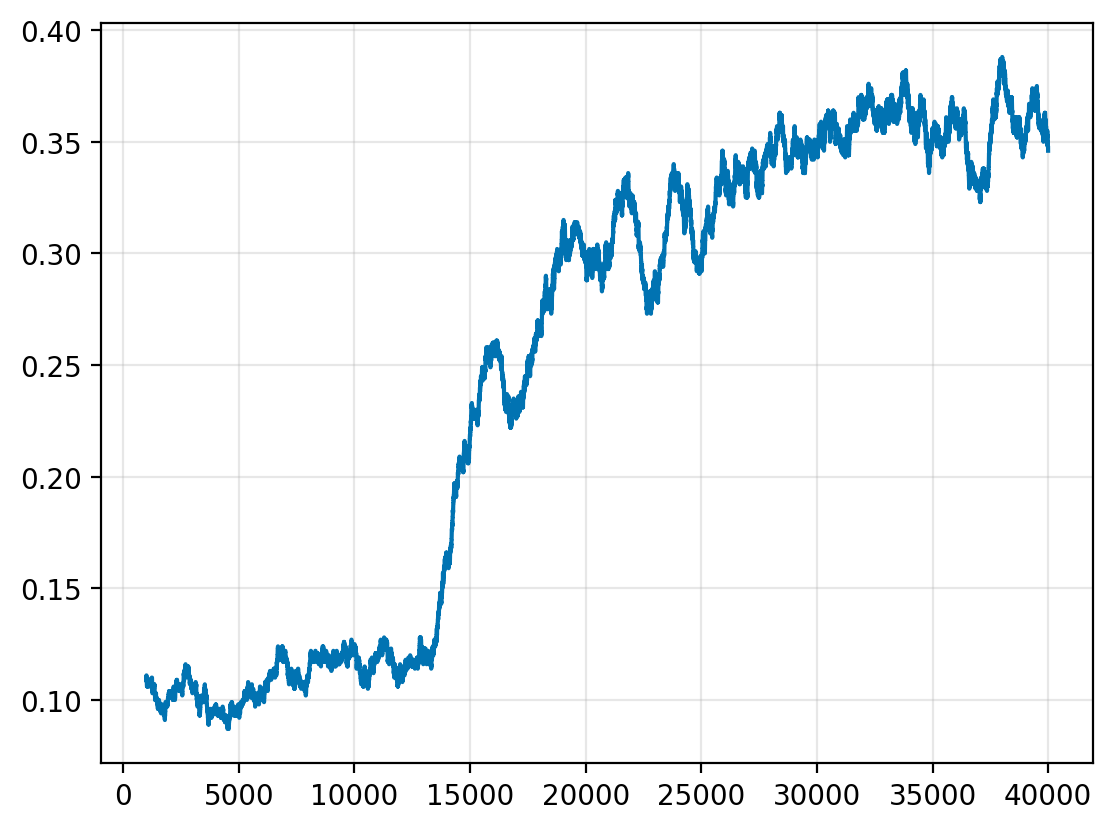

In [358]:
pd.Series(rewards_lll).rolling(1000).mean().plot(label=r"$\epsilon$-greedy")
plt.grid(alpha=0.3)

## Neural bandits: partial information setting (Thompson sampling)

In [350]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        return eta


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [351]:
def step(state, t):
    key_step = jax.random.fold_in(key_run, t)
    key_step, key_take = jax.random.split(key_step)
    
    bel, context, env_state = state
    
    # Take action
    yhat = agent.sample_predictive(key_take, bel, context[..., None])
    action = yhat.argmax()
    
    # Obtain reward
    y = jax.nn.one_hot(env_state.correct_label, 10)[action]

    # Update belief
    X = (action, context[..., None])
    bel_update = agent.update(bel, y, X)

    # Take next step
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)

    return (bel_update, context_new, env_state), (action, reward)

In [352]:
%%time
agent = onflow.LowRankLastLayer(
    mean_fn,
    cov_fn,
    rank=50,
    dynamics_hidden=0.0,
    dynamics_last=0.0
)


bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)
u_init = (bel_init, context_init, state_init)

state_final, (actions, rewards_ts) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_ts = jax.block_until_ready((rewards_ts + 1) / 2)

CPU times: user 20.7 s, sys: 643 ms, total: 21.3 s
Wall time: 32 s


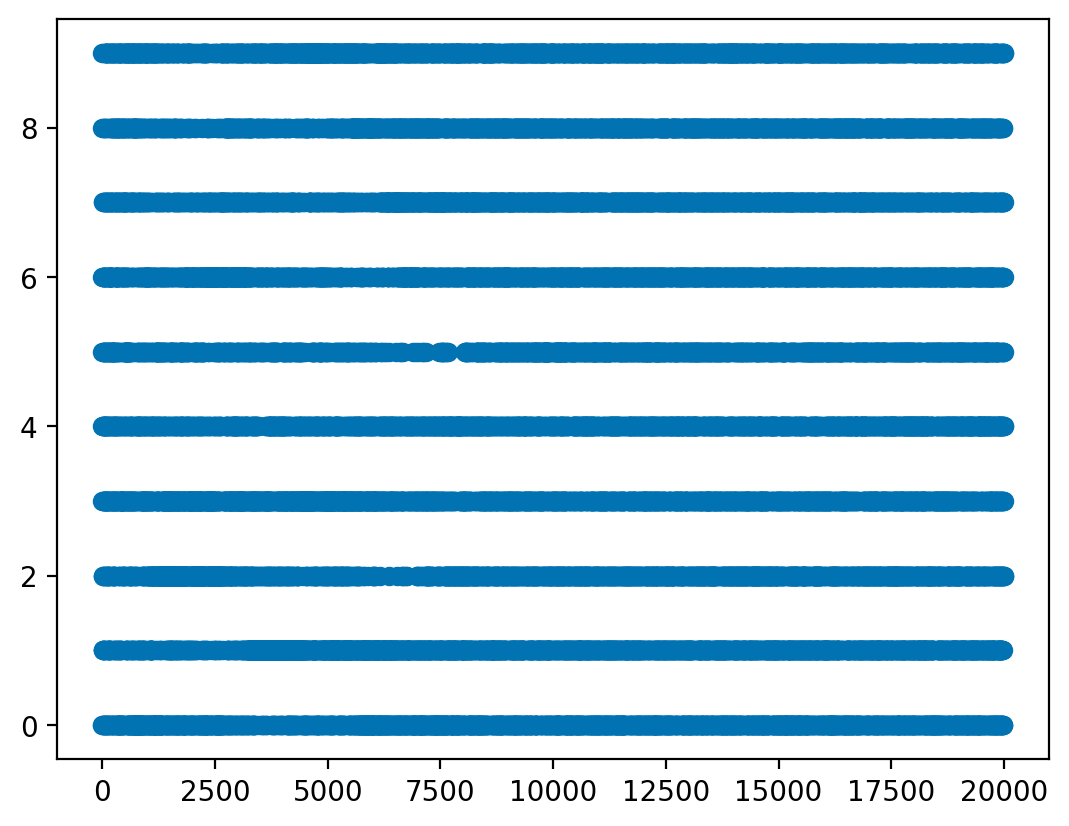

In [354]:
plt.scatter(jnp.arange(steps), actions)

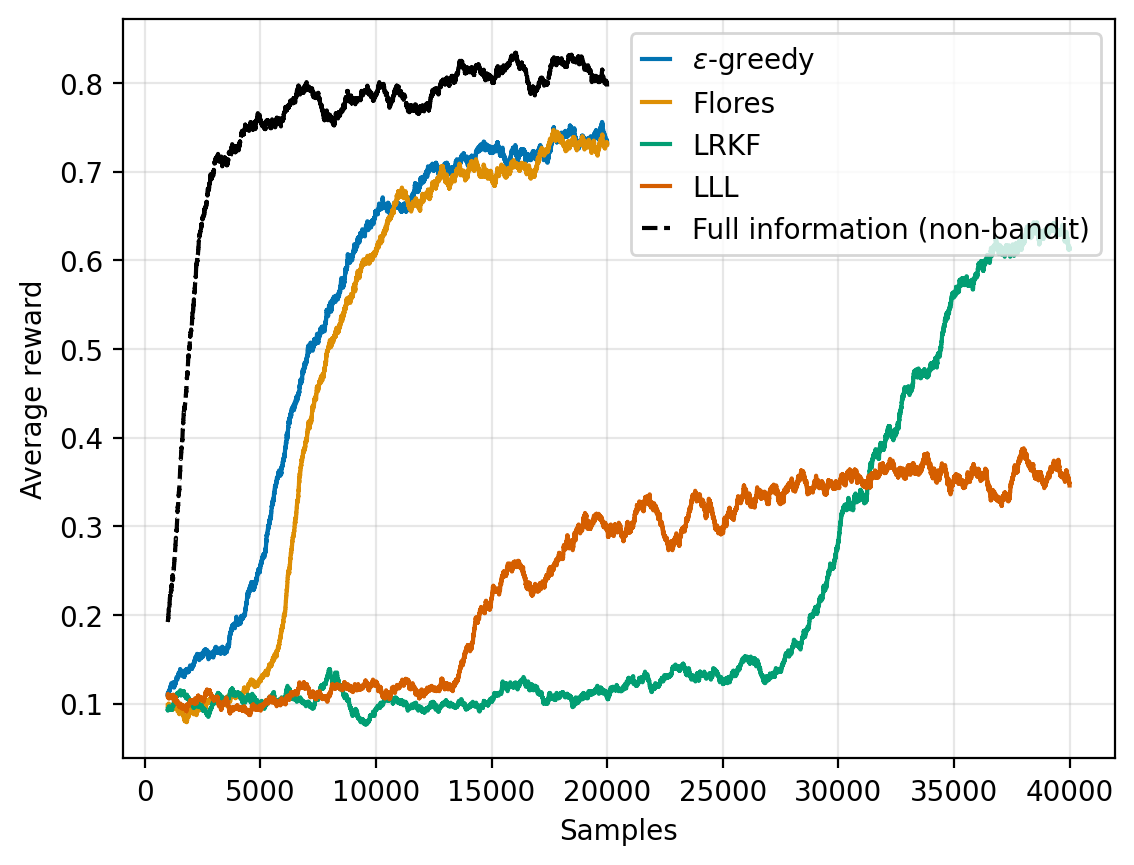

In [355]:
window = 1000
pd.Series(rewards_eps).rolling(window).mean().plot(label=r"$\epsilon$-greedy")
pd.Series(rewards_ts).rolling(window).mean().plot(label="Flores")
pd.Series(rewards_lrkf).rolling(window).mean().plot(label="LRKF")
pd.Series(rewards_lll).rolling(window).mean().plot(label="LLL")
pd.Series(rewards_fullinfo).rolling(window).mean().plot(label="Full information (non-bandit)", c="black", linestyle="--")
plt.ylabel("Average reward")
plt.xlabel("Samples")
plt.legend(handlelength=1)
plt.grid(alpha=0.3)

## TS LoFi

In [38]:
from rebayes_mini.methods import low_rank_filter as lofi

In [39]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        mean = jax.nn.softmax(eta)
        return mean


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(jnp.atleast_1d(eta))
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [40]:
%%time
dynamics = 1e-3
agent = lofi.LowRankPrecisionFilter(
    mean_fn, cov_fn, dynamics_covariance=dynamics, rank=50
)

bel_init = agent.init_bel(params_init, cov=1.0)
u_init = (bel_init, context_init, state_init)

(bel_final, _, _), (actions, rewards_lofi) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_lofi = jax.block_until_ready((rewards_lofi + 1) / 2)

CPU times: user 17.5 s, sys: 934 ms, total: 18.4 s
Wall time: 21.5 s


In [41]:
bel_final.mean

Array([-0.08056089, -0.32216856, -0.36515394, ..., -0.03197391,
       -0.08368497, -0.14402401], dtype=float32)

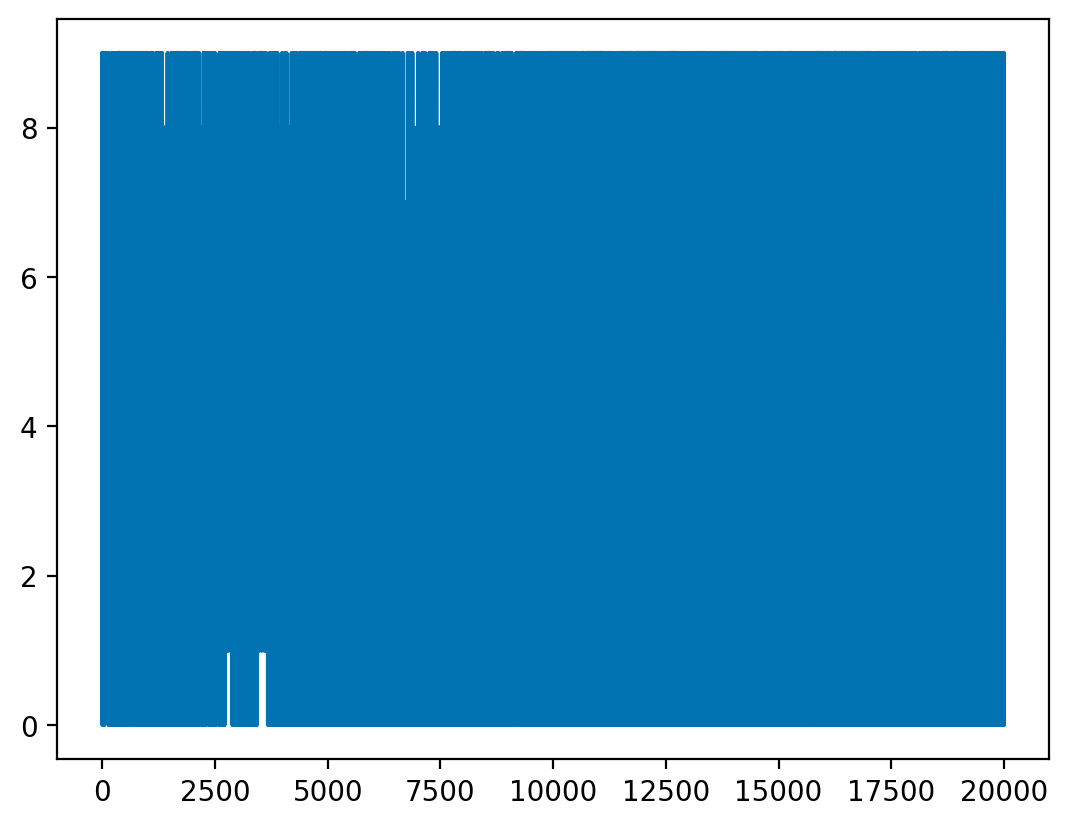

In [42]:
plt.plot(actions)

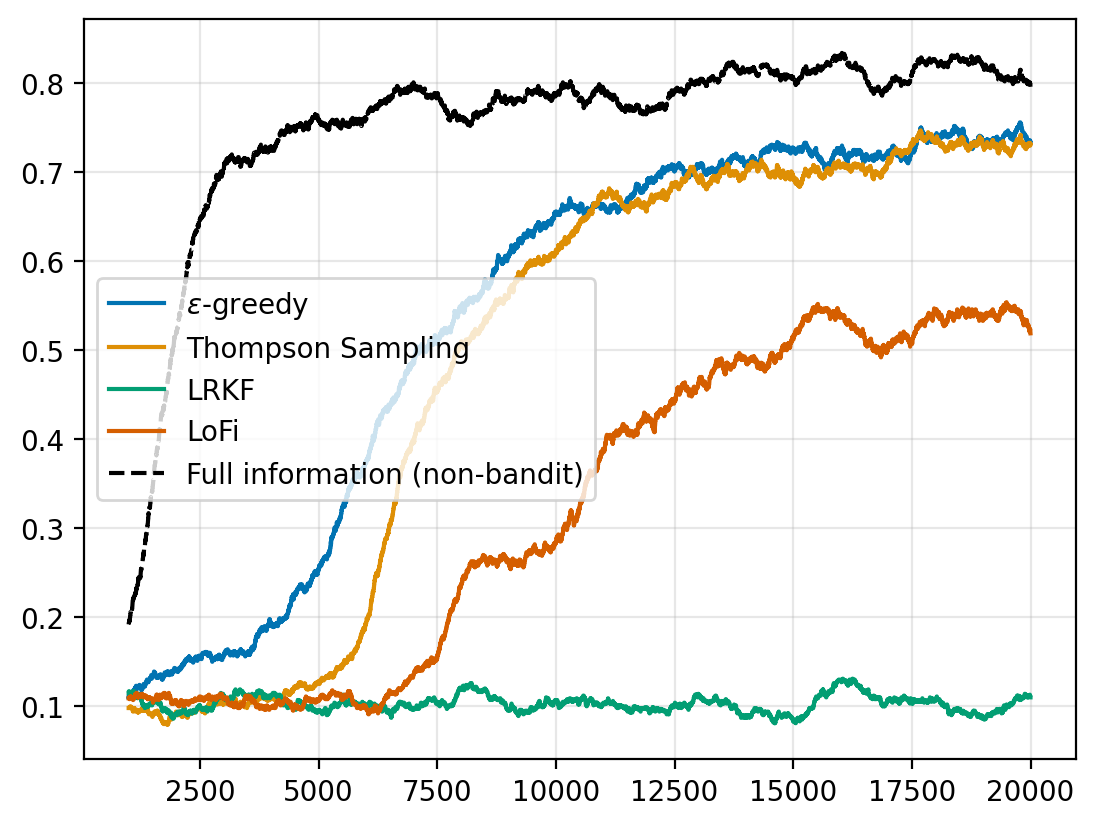

In [43]:
window = 1000
pd.Series(rewards_eps).rolling(window).mean().plot(label=r"$\epsilon$-greedy")
pd.Series(rewards_ts).rolling(window).mean().plot(label="Thompson Sampling")
pd.Series(rewards_lrkf).rolling(window).mean().plot(label="LRKF")
pd.Series(rewards_lofi).rolling(window).mean().plot(label="LoFi")
pd.Series(rewards_fullinfo).rolling(window).mean().plot(label="Full information (non-bandit)", c="black", linestyle="--")
plt.legend()
plt.grid(alpha=0.3)

## LRKF - TS

In [109]:
def mean_fn(params, x):
    if isinstance(x, tuple):
        action = x[0]
        x = x[1]
        eta = model.apply(params, x)
        mean = jax.nn.sigmoid(eta[action])
        return jnp.atleast_1d(mean)
    else:
        eta = model.apply(params, x)
        mean = jax.nn.softmax(eta)
        return mean


def cov_fn(eta, eps=0.1):
    mean = jax.nn.softmax(eta)
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [115]:
%%time
dynamics = 1e-3
agent = lrkf.LowRankCovarianceFilter(
    mean_fn, cov_fn, dynamics_covariance=dynamics, rank=50
)

bel_init = agent.init_bel(params_init, cov=1.0, low_rank_diag=True)
u_init = (bel_init, context_init, state_init)
steps = 40_000

(bel_final, _, _), (actions, rewards_lrkf_ts) = jax.lax.scan(step, u_init, jnp.arange(steps))
rewards_lrkf_ts = jax.block_until_ready((rewards_lrkf_ts + 1) / 2)

CPU times: user 51.7 ms, sys: 5.23 ms, total: 56.9 ms
Wall time: 16.3 s


In [116]:
pdist = agent.predictive_density(bel_final, context[..., None])

In [117]:
pdist.sample(seed=key)

Array([ 0.06637992,  0.6359299 , -0.5002055 , -0.30198795, -0.20351344,
        0.86675894, -0.15104961,  0.33500373,  0.85564595,  0.12270252],      dtype=float32)

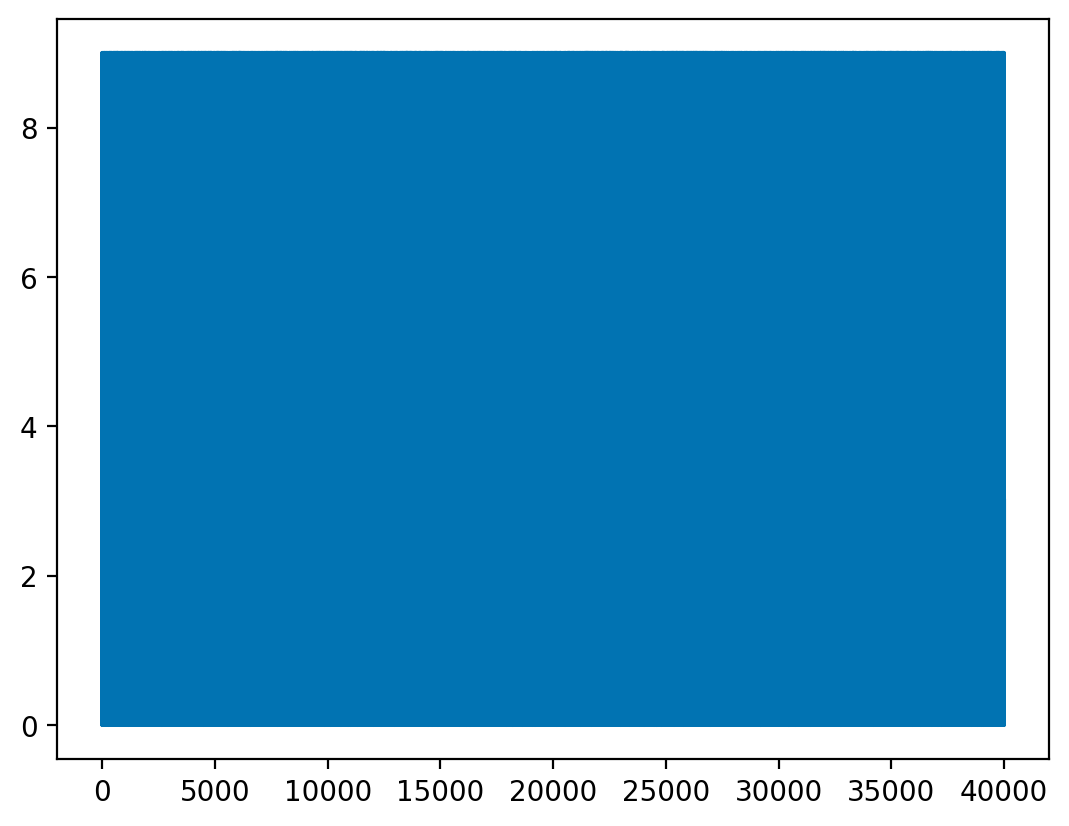

In [118]:
plt.plot(actions)

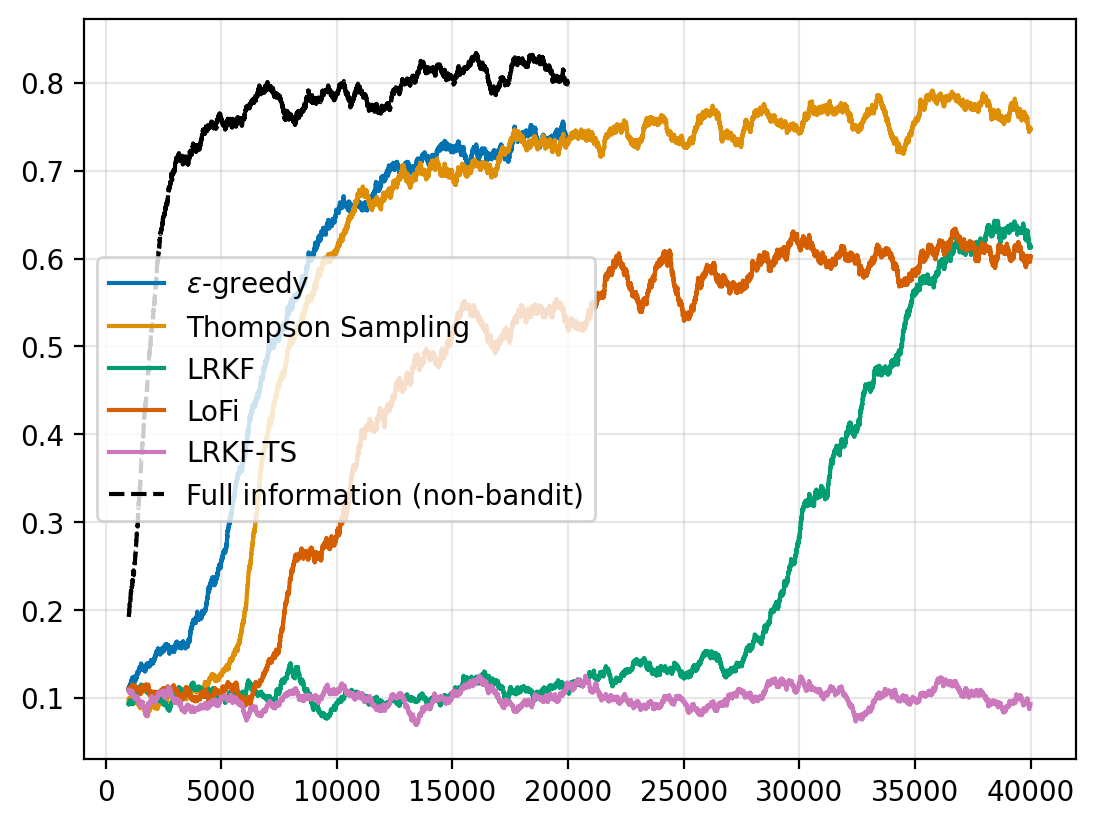

In [119]:
window = 1000
pd.Series(rewards_eps).rolling(window).mean().plot(label=r"$\epsilon$-greedy")
pd.Series(rewards_ts).rolling(window).mean().plot(label="Thompson Sampling")
pd.Series(rewards_lrkf).rolling(window).mean().plot(label="LRKF")
pd.Series(rewards_lofi).rolling(window).mean().plot(label="LoFi")
pd.Series(rewards_lrkf_ts).rolling(window).mean().plot(label="LRKF-TS")
pd.Series(rewards_fullinfo).rolling(window).mean().plot(label="Full information (non-bandit)", c="black", linestyle="--")
plt.legend()
plt.grid(alpha=0.3)

## Gym lunar lander

In [667]:
%config InlineBackend.figure_format = "retina"

In [111]:
import gym

In [195]:
import jax
import jax.numpy as jnp

In [646]:
import matplotlib.pyplot as plt

In [682]:
from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import base_filter

In [683]:
env = gym.make("LunarLander-v2")

In [684]:
class LinearPolicy(nn.Module):
    n_actions: int
    n_features: int
    
    @nn.compact
    def __call__(self, x):
        a = x[..., 0]
        x = x[..., 1:]
        embedding = nn.Embed(self.n_actions, self.n_features)(a.astype(int))
        x = jnp.einsum("...j,...j->...", embedding, x)
        return x

In [685]:
key = jax.random.PRNGKey(314)
X_init = jnp.ones(env.observation_space.shape[0] + 1)
model = LinearPolicy(n_actions=env.action_space.n, n_features=env.observation_space.shape[0])
params_init = model.init(key, X_init[None, :])
jax.tree.map(jnp.shape, params_init)

{'params': {'Embed_0': {'embedding': (4, 8)}}}

In [757]:
agent = lrkf.LowRankCovarianceFilter(
    model.apply,
    lambda x: jnp.eye(1) * 1.0,
    dynamics_covariance=1e-4,
    rank=32
)


# agent = base_filter.ExtendedFilter(
#     model.apply,
#     lambda x: jnp.eye(1) * 1.0,
#     dynamics_covariance=0.0
# )

@jax.jit
def sample_predictives(key, bel, state):
    state = jnp.atleast_1d(state)
    actions = jnp.arange(4)
    keys = jax.random.split(key, 4)
    @jax.vmap
    def _sample(key, action):
        X = jnp.c_[action, state]
        sample = agent.sample_predictive(key, bel_init, X)
        return sample
    samples = _sample(keys, actions)
    return samples

In [758]:
from tqdm import tqdm

In [761]:
@jax.jit
def update(bel, y, X):
    return agent.update(bel, y, X[None, :])

In [764]:
gamma = 0.9999
state_prev, _ = env.reset(seed=314)
action_prev = 0
bel_init = agent.init_bel(params_init, cov=10.0)
bel = bel_init

steps = 8_000
episode_reward = 0.0
final_rewards = []
n_episodes = 0
ewm_episode = 0.0
rewards = np.zeros(steps)

for s in (pbar := tqdm(range(steps))):
    key_t = jax.random.fold_in(key, s)
    action_value_samples = sample_predictives(key_t, bel, state_prev[None, :])
    action = action_value_samples.argmax().item()
    state_next, reward, terminated, truncated, info = env.step(action)
    
    if terminated:
        _, key_new = jax.random.split(key_t)
        state_prev, info = env.reset()
        action_value_samples = sample_predictives(key_t, bel, state_prev[None, :])
        action = action_value_samples.argmax().item()
        final_rewards.append(episode_reward)
        ewm_episode = 0.3 * episode_reward + (1 - 0.3) * ewm_episode
        pbar.set_description(f"EWM @ {n_episodes}: {ewm_episode:0.2f}")
        episode_reward = 0.0
        n_episodes += 1
        continue
    else:
        rewards[s] = reward
        episode_reward += reward
    
    X_prev = jnp.insert(state_prev, 0, jnp.array([action_prev]))
    
    X_next = jnp.insert(state_next, 0, jnp.array([action]), 0)
    y = reward + gamma * agent.mean_fn(bel.mean, X_next)
    
    state_prev = state_next
    action_prev = action
    
    # bel = agent.update(bel, y, X_next[None, :])
    # bel = agent.update(bel, bel, y, X_prev[None, :])
    bel = update(bel, y, X_prev)

EWM @ 60: -111.05: 100%|█████████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:33<00:00, 52.27it/s]


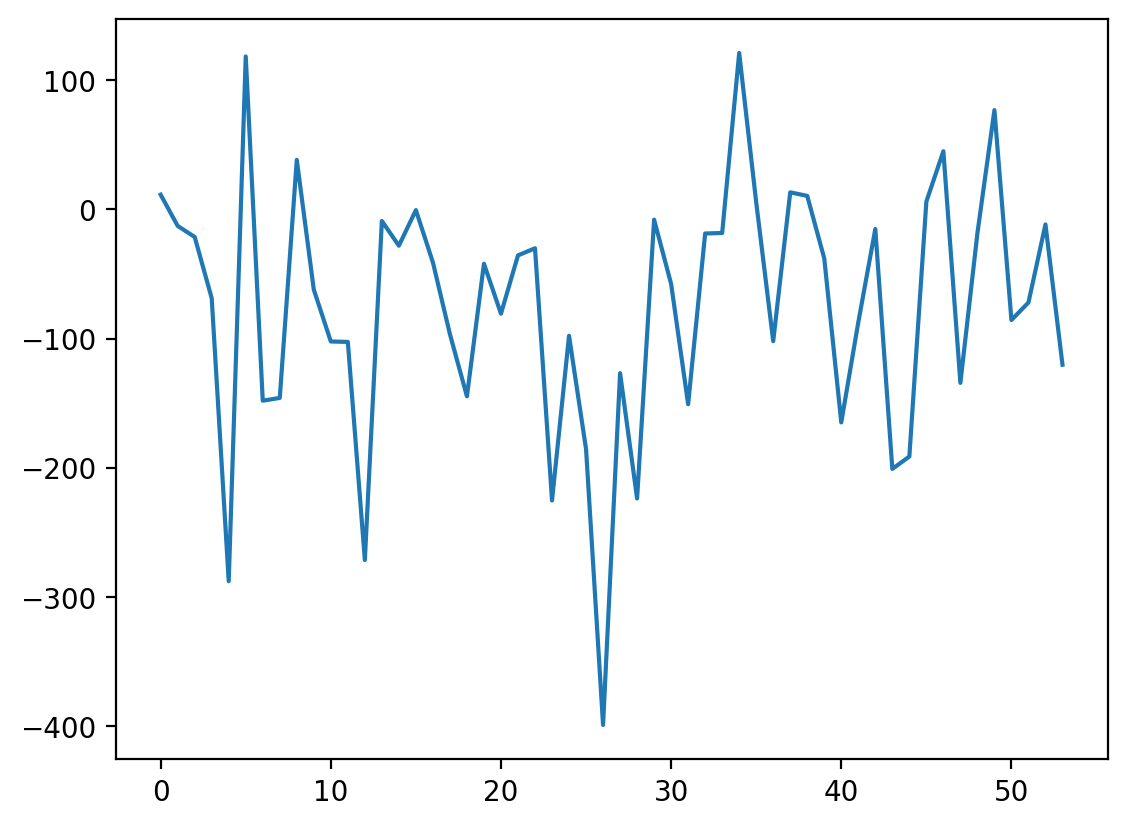

In [763]:
plt.plot(np.array(final_rewards))

In [618]:
action_value_samples = sample_predictives(key, bel, state_prev[None, :])
action = action_value_samples.argmax().item()

In [619]:
state_next, reward, terminated, truncated, info = env.step(action)

In [620]:
X_prev = jnp.insert(observation_next, 0, jnp.array([action_prev]))
yhat = agent.mean_fn(bel_init.mean, X_prev)

In [621]:
X_next = jnp.insert(observation_next, 0, jnp.array([action]), 0)
y = reward + gamma * agent.mean_fn(bel_init.mean, X_next)
state_prev = state_next

In [622]:
reward

np.float64(0.4749850519668257)